# Modelo de Rede Neural para Predição de Matrículas

### 1 - Importando bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import seaborn as sns

### 2 - Pasta de Arquivos

In [2]:
path_arquivos = r'/Users/fernandofelisardo/Downloads/Arquivos'
path_matriculas = r'/Users/fernandofelisardo/Downloads/Arquivos/matriculas'
path_parcelas = r'/Users/fernandofelisardo/Downloads/Arquivos/parcela'
path_itens = r'/Users/fernandofelisardo/Downloads/Arquivos/item3'

### 3 - Função que compila arquivos

In [3]:
def compila_arquivos(pasta):
    lista = os.listdir(pasta)
    df = pd.read_csv(os.path.join(pasta, lista[0]), encoding='ISO-8859-1', sep=';')
    for i in range(1,len(lista)):
        temp = pd.read_csv(os.path.join(pasta, lista[i]), encoding='ISO-8859-1', sep=';')
        temp = pd.DataFrame(temp)
        df = pd.concat([df,temp], axis=0, ignore_index=True)
    return df

### 4 - Criando dataframe de matriculas

In [4]:
matriculas = compila_arquivos(path_matriculas)

/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:5: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(os.path.join(pasta, lista[i]), encoding='ISO-8859-1', sep=';')
/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,temp], axis=0, ignore_index=True)
/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the o

### 5 - Filtrando Status

In [5]:
lista_status = ['Anulado', 'Transferido', 'Pré Matricula', 'Pré Matrícula']
matriculas_filtrado = matriculas[~matriculas['Status'].isin(lista_status)]
matriculas_filtrado = matriculas_filtrado.dropna(subset='Status')

### 6 - Convertendo datas

In [6]:
matriculas_filtrado['Data Matricula'] = pd.to_datetime(matriculas_filtrado['Data Matricula'], format='%Y-%m-%d', errors='coerce')
matriculas_filtrado['ano_referencia'] = matriculas_filtrado['Data Matricula'].dt.year
matriculas_filtrado['mes_referencia'] = matriculas_filtrado['Data Matricula'].dt.month

### 7 - Apurando quantidade de orientadores

In [7]:
orientador = matriculas_filtrado.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['Orientador'].nunique().reset_index()
display(orientador)

,Unidade,ano_referencia,mes_referencia,Orientador
0,Anápolis,2014,12,6
1,Anápolis,2015,1,5
2,Anápolis,2015,2,5
3,Anápolis,2015,3,6
4,Anápolis,2015,4,5
...,...,...,...,...
10721,Vitória da Conquista,2023,5,7
10722,Vitória da Conquista,2023,6,5
10723,Vitória da Conquista,2023,7,6
10724,Vitória da Conquista,2023,8,5


### 8 - Importando arquivo de agendamentos e convertendo datas

In [8]:
visitas = compila_arquivos(path_itens)
visitas['Agendamento'] = pd.to_datetime(visitas['Agendamento'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
visitas.dropna(subset='Agendamento', inplace=True)
visitas['ano_referencia'] = visitas['Agendamento'].dt.year.round(0).astype(int)
visitas['mes_referencia'] = visitas['Agendamento'].dt.month.round(0).astype(int)

/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(os.path.join(pasta, lista[i]), encoding='ISO-8859-1', sep=';')
/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(os.path.join(pasta, lista[i]), encoding='ISO-8859-1', sep=';')
/var/folders/99/yhp42x_x0d79tj7xb4cdvjs80000gn/T/ipykernel_3353/1194789675.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(os.path.join(pasta, lista[i]), encoding='ISO-8859-1', sep=';')


### 9 - Criando dataframe de agendamentos

In [9]:
agendamentos_filtrado = visitas.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['Nome'].count().reset_index()
agendamentos_filtrado.rename(columns={'Nome':'Agendamentos'}, inplace=True)
display(agendamentos_filtrado)

,Unidade,ano_referencia,mes_referencia,Agendamentos
0,Anápolis,2023,3,435
1,Anápolis,2023,4,302
2,Anápolis,2023,5,379
3,Anápolis,2023,6,664
4,Anápolis,2023,7,653
...,...,...,...,...
517,Vitória da Conquista,2023,5,596
518,Vitória da Conquista,2023,6,499
519,Vitória da Conquista,2023,7,639
520,Vitória da Conquista,2023,8,787


### 10 - Criando dataframe de visitas

In [10]:
lista_visitas = ['Matrícula', 'Pré Matrícula', 'Sem cond. no momento', 'Para Atender', 'Vai pensar', 'Sem interesse', 'Vai pesquisar', 'Sem financeiro', 'Atendimento Presencial', 'Matricula']
visitas_filtrado = visitas[visitas['Status'].isin(lista_visitas)]
display(visitas_filtrado.info())
visitas_filtrado2 = visitas_filtrado.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['Nome'].count().reset_index()
visitas_filtrado2.rename(columns={'Nome':'Visitas'}, inplace=True)
display(visitas_filtrado2)

<class 'pandas.core.frame.DataFrame'>
Index: 68647 entries, 1 to 228507
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      0 non-null      object        
 1   Data Coleta     68647 non-null  object        
 2   Unidade         68647 non-null  object        
 3   Nome            68647 non-null  object        
 4   Data            68415 non-null  object        
 5   Retorno         7479 non-null   object        
 6   Telefone        24635 non-null  object        
 7   Celular         66342 non-null  object        
 8   Comercial       16528 non-null  object        
 9   Curso           48931 non-null  object        
 10  Fonte           68632 non-null  object        
 11  Captador        68640 non-null  object        
 12  Orientador      66295 non-null  object        
 13  Contratos       31841 non-null  object        
 14  Cursos          31841 non-null  object        
 15  Matric

None

,Unidade,ano_referencia,mes_referencia,Visitas
0,Anápolis,2023,3,415
1,Anápolis,2023,4,299
2,Anápolis,2023,5,364
3,Anápolis,2023,6,317
4,Anápolis,2023,7,269
...,...,...,...,...
511,Vitória da Conquista,2023,5,103
512,Vitória da Conquista,2023,6,91
513,Vitória da Conquista,2023,7,122
514,Vitória da Conquista,2023,8,133


### 11 - Criando dataframe de Matriculas Travado

In [11]:
matriculas_travado = pd.read_csv(os.path.join(path_arquivos, 'dados_indicadores_f10.csv'), encoding='UTF-8', sep=',')
matriculas_travado['data_referencia'] = pd.to_datetime(matriculas_travado['data_referencia'], format='%d/%m/%Y', dayfirst=True)
matriculas_travado['ano_referencia'] = matriculas_travado['data_referencia'].dt.year
matriculas_travado['mes_referencia'] = matriculas_travado['data_referencia'].dt.month
matriculas_travado.rename(columns={'unidade':'Unidade'}, inplace=True)
display(matriculas_travado.info())
visao_matriculas = matriculas_travado.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['matriculas'].sum().reset_index()
display(visao_matriculas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unidade             1663 non-null   object        
 1   data_referencia     1663 non-null   datetime64[ns]
 2   faturamento         1624 non-null   object        
 3   visita              1662 non-null   float64       
 4   matriculas          1662 non-null   float64       
 5   conv_matriculas     1570 non-null   object        
 6   retencao            1610 non-null   object        
 7   despesas            1624 non-null   object        
 8   lucratividade       1618 non-null   object        
 9   ticket_material     1521 non-null   object        
 10  ticket_recebimento  1583 non-null   object        
 11  ticket_parcela      1604 non-null   object        
 12  mes_atual           1618 non-null   object        
 13  30_dias             1606 non-null   object      

None

,Unidade,ano_referencia,mes_referencia,matriculas
0,Anápolis,2022,1,128.0
1,Anápolis,2022,2,80.0
2,Anápolis,2022,3,106.0
3,Anápolis,2022,4,95.0
4,Anápolis,2022,5,103.0
...,...,...,...,...
1658,Vitória da Conquista,2023,5,74.0
1659,Vitória da Conquista,2023,6,80.0
1660,Vitória da Conquista,2023,7,91.0
1661,Vitória da Conquista,2023,8,101.0


In [12]:
despesas = pd.read_csv(os.path.join(path_arquivos, "_Despesas.csv"), encoding='ISO-8859-1', sep=';')
despesas.rename(columns={'unidade':'Unidade'}, inplace=True)
despesas['quitacao'] = pd.to_datetime(despesas['quitacao'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
despesas['ano_referencia'] = despesas['quitacao'].dt.year
despesas['mes_referencia'] = despesas['quitacao'].dt.month
midia = despesas[despesas['conta'] == "Mídias Sociais"]
salarios = despesas[despesas['conta'] == "Salários"]
despesas.info()
# Mídias Sociais
# Salários
view_midia = midia.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['valorpago'].sum().sort_values(ascending=False).reset_index()
view_midia.rename(columns={'valorpago':'midia'}, inplace=True)
display(view_midia)
view_salario = salarios.groupby(['Unidade', 'ano_referencia', 'mes_referencia'])['valorpago'].sum().sort_values(ascending=False).reset_index()
view_salario.rename(columns={'valorpago':'salarios'}, inplace=True)
display(view_salario)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185796 entries, 0 to 185795
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Data Coleta     185796 non-null  object        
 1   Unidade         185796 non-null  object        
 2   quitacao        185796 non-null  datetime64[ns]
 3   vencimento      185796 non-null  object        
 4   valorpago       185796 non-null  float64       
 5   conta           185790 non-null  object        
 6   contapai        185790 non-null  object        
 7   apelido         185791 non-null  object        
 8   ano_referencia  185796 non-null  int32         
 9   mes_referencia  185796 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(6)
memory usage: 12.8+ MB


,Unidade,ano_referencia,mes_referencia,midia
0,Chapecó,2022,10,16435.54
1,Teófilo Otoni,2023,8,16389.31
2,Franca,2023,5,15356.29
3,Curitiba,2022,9,14235.68
4,Campos dos Goytacazes,2023,8,14079.37
...,...,...,...,...
677,Lençóis,2023,4,110.00
678,Porto Ferreira,2022,10,57.00
679,Santa Luzia,2023,6,20.97
680,Itapevi,2022,10,10.90


,Unidade,ano_referencia,mes_referencia,salarios
0,Rondonópolis,2023,8,99482.59
1,Rondonópolis,2022,11,98392.10
2,Rondonópolis,2023,4,96724.19
3,Rondonópolis,2022,8,96281.47
4,Rondonópolis,2022,9,96027.52
...,...,...,...,...
986,Conselheiro Lafaiete,2022,12,180.00
987,Conselheiro Lafaiete,2023,8,138.00
988,Barbacena,2023,8,127.28
989,Barbacena,2023,4,84.00


### 12 - Concatenando informações

In [13]:
visao_geral = orientador.merge(agendamentos_filtrado, how='left', on=['Unidade', 'ano_referencia', 'mes_referencia'])
visao_geral = visao_geral.merge(visitas_filtrado2, how='left', on=['Unidade', 'ano_referencia', 'mes_referencia'])
visao_geral = visao_geral.merge(visao_matriculas, how='left', on=['Unidade', 'ano_referencia', 'mes_referencia'])
visao_geral = visao_geral.merge(view_midia, how='left', on=['Unidade', 'ano_referencia', 'mes_referencia'])
visao_geral = visao_geral.merge(view_salario, how='left', on=['Unidade', 'ano_referencia', 'mes_referencia'])
display(visao_geral)

,Unidade,ano_referencia,mes_referencia,Orientador,Agendamentos,Visitas,matriculas,midia,salarios
0,Anápolis,2014,12,6,NaN,NaN,NaN,NaN,NaN
1,Anápolis,2015,1,5,NaN,NaN,NaN,NaN,NaN
2,Anápolis,2015,2,5,NaN,NaN,NaN,NaN,NaN
3,Anápolis,2015,3,6,NaN,NaN,NaN,NaN,NaN
4,Anápolis,2015,4,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10721,Vitória da Conquista,2023,5,7,596.0,103.0,74.0,3045.0,27294.22
10722,Vitória da Conquista,2023,6,5,499.0,91.0,80.0,2240.0,27166.08
10723,Vitória da Conquista,2023,7,6,639.0,122.0,91.0,2100.0,26054.83
10724,Vitória da Conquista,2023,8,5,787.0,133.0,101.0,4025.0,27290.52


### 13 - Filtrando ano e informações vazias

In [14]:
# visao_geral = visao_geral[visao_geral['ano_referencia'] >= 2022]
# visao_geral = visao_geral[visao_geral['mes_referencia'] >= 5]
visao_geral.dropna(inplace=True)

### 14 - Criando Função que conta dias uteis

In [15]:
# Função para calcular dias úteis
def calcular_dias_uteis(row):
    ano = row['ano_referencia']
    mes = row['mes_referencia']
    primeiro_dia = datetime(ano, mes, 1)
    ultimo_dia = (primeiro_dia + pd.offsets.MonthEnd()).date()
    
    # Convertendo para datetime.date antes de calcular a diferença
    primeiro_dia = primeiro_dia.date()
    ultimo_dia = ultimo_dia

    dias_uteis = np.busday_count(primeiro_dia, ultimo_dia)
    return dias_uteis


visao_geral['dias_uteis'] = visao_geral.apply(calcular_dias_uteis, axis=1)

### 15 -  Criando matriz correlacional

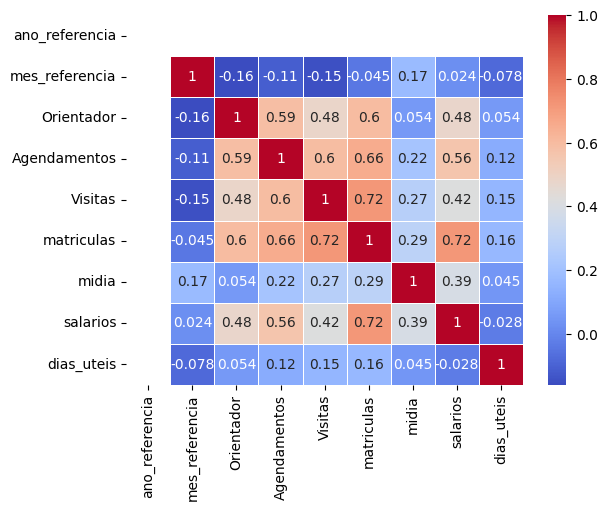

In [16]:
dados = visao_geral.copy()
dados.drop(columns='Unidade', inplace=True)
matriz_correlacao = dados.corr()
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

### 16 -  Criando Ids de unidades e dropando dados desnecessários

In [17]:
label_encoder = LabelEncoder()
visao_geral['Unidade_id'] = label_encoder.fit_transform(visao_geral['Unidade'])
# visao_geral = visao_geral[visao_geral['Unidade'] == "Londrina"]
selecao_ids = visao_geral[['Unidade', 'Unidade_id']]
# visao_geral.drop(columns=['Unidade', 'ano_referencia', 'mes_referencia', 'dias_uteis'], inplace=True)
display(visao_geral.info())

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 99 to 10724
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unidade         322 non-null    object 
 1   ano_referencia  322 non-null    int32  
 2   mes_referencia  322 non-null    int32  
 3   Orientador      322 non-null    int64  
 4   Agendamentos    322 non-null    float64
 5   Visitas         322 non-null    float64
 6   matriculas      322 non-null    float64
 7   midia           322 non-null    float64
 8   salarios        322 non-null    float64
 9   dias_uteis      322 non-null    int64  
 10  Unidade_id      322 non-null    int64  
dtypes: float64(5), int32(2), int64(3), object(1)
memory usage: 27.7+ KB


None

# Construção do Modelo Neural

### 1 - Separando dados X e Y

In [18]:
X = visao_geral[['Orientador', 'Agendamentos', 'Visitas', 'midia', 'salarios','Unidade_id']].values
y = visao_geral['matriculas'].values

### 2 - Separando dados de treino e teste

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

In [20]:
from sklearn.preprocessing import StandardScaler

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


### 3 - Convertendo para tensores

In [21]:
# Converta seus dados para tensores PyTorch
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

### 4 -  Criando dataloader

In [22]:
# Crie DataLoader para treinamento e validação
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch = 32
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

### 5 - Criando rede neural

In [23]:
# Crie sua arquitetura de modelo para regressão
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 140),
            nn.ReLU(),
            nn.Dropout(1e-8),
            nn.Linear(140,1)
        )

    def forward(self, x):
       return  self.layers(x)

### 6 - Instanciando modelo

In [24]:
# Instancie o modelo e escolha a função de perda e otimizador
model = RegressionModel()
criterion = nn.MSELoss()  # Mean Squared Error Loss para tarefas de regressão
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)

### 7 - Early Stop

In [25]:
# Defina o Early Stopping
early_stopping = {'patience': 3, 'verbose': True, 'delta': 0.001, 'counter': 0, 'best_loss': float('inf')}


#### early_stopping['patience']: Número de épocas que você está disposto a esperar para ver uma melhoria.
#### early_stopping['delta']: A quantidade mínima de melhoria para considerar como uma melhoria significativa.

### Erro Quadrático Médio (MSE - Mean Squared Error):
MSE = 1/n * Σ(y_true - y_pred)^2
Mede a média dos quadrados das diferenças entre os valores previstos e os valores reais. Quanto menor o MSE, melhor.
### Raiz do Erro Quadrático Médio (RMSE):
RMSE = sqrt(MSE)
É a raiz quadrada do MSE e fornece uma medida na mesma escala dos rótulos originais.
### Erro Absoluto Médio (MAE - Mean Absolute Error):
MAE = 1/n * Σ|y_true - y_pred|
Mede a média das diferenças absolutas entre os valores previstos e os valores reais.
### Coeficiente de Determinação (R²):
R² = 1 - (Σ(y_true - y_pred)^2) / Σ(y_true - mean(y_true))^2
Indica a proporção da variabilidade nos rótulos que é explicada pelo modelo. Quanto mais próximo de 1, melhor.
### Erro Percentual Absoluto Médio (MAPE - Mean Absolute Percentage Error):
MAPE = 1/n * Σ(|(y_true - y_pred) / y_true|) * 100
Mede a média percentual das diferenças absolutas entre os valores previstos e os valores reais.

### 8 - Treinando o modelo

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


# Treine o modelo para regressão com Early Stopping
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Avalie no conjunto de validação
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.view(-1, 1)).item()
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy())

    val_loss /= len(val_loader)

    # Calcula métricas adicionais
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Verifique se o Early Stopping deve ser aplicado
    if val_loss < early_stopping['best_loss'] - early_stopping['delta']:
        early_stopping['best_loss'] = val_loss
        early_stopping['counter'] = 0
    else:
        early_stopping['counter'] += 1
        if early_stopping['counter'] >= early_stopping['patience']:
            print("Early stopping after {} epochs.".format(epoch))
            break

    print("Epoch {}: Training Loss: {:.4f}, Validation Loss: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}"
          .format(epoch, loss.item(), val_loss, mse, rmse, mae, r2))

Epoch 0: Training Loss: 5682.2910, Validation Loss: 7456.9914, MSE: 6451.7759, RMSE: 80.3229, MAE: 72.4603, R²: -4.2316
Epoch 1: Training Loss: 2891.4263, Validation Loss: 6157.5282, MSE: 5469.8135, RMSE: 73.9582, MAE: 66.0678, R²: -3.4353
Epoch 2: Training Loss: 1310.3666, Validation Loss: 4293.8465, MSE: 4032.3264, RMSE: 63.5006, MAE: 56.1556, R²: -2.2697
Epoch 3: Training Loss: 4022.1504, Validation Loss: 2210.8310, MSE: 2369.7964, RMSE: 48.6806, MAE: 42.5368, R²: -0.9216
Epoch 4: Training Loss: 3098.4985, Validation Loss: 780.2156, MSE: 1089.4348, RMSE: 33.0066, MAE: 27.2505, R²: 0.1166
Epoch 5: Training Loss: 944.9585, Validation Loss: 525.5239, MSE: 642.4347, RMSE: 25.3463, MAE: 21.4180, R²: 0.4791
Epoch 6: Training Loss: 554.9491, Validation Loss: 738.0876, MSE: 647.6901, RMSE: 25.4498, MAE: 20.3673, R²: 0.4748
Epoch 7: Training Loss: 1693.7430, Validation Loss: 561.5833, MSE: 522.7109, RMSE: 22.8629, MAE: 18.9478, R²: 0.5761
Epoch 8: Training Loss: 11.3057, Validation Loss: 424

In [27]:
# Avaliando o modelo no conjunto de teste
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    test_loss = criterion(y_pred, y_val_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 310.0069


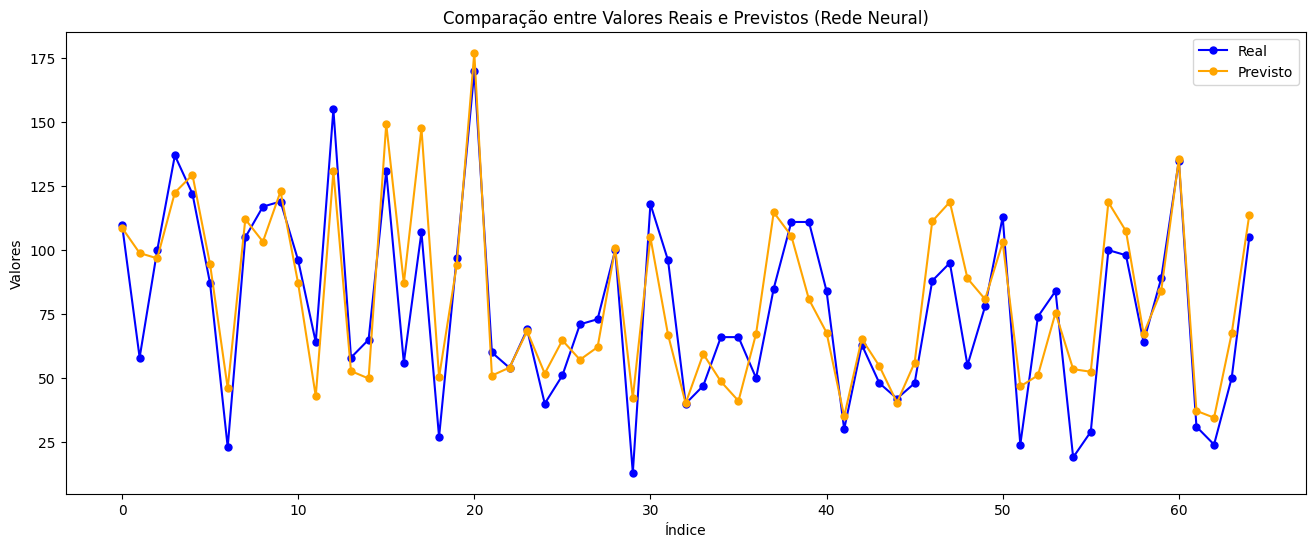

In [28]:
# Convertendo tensores de volta para numpy arrays
y_test_tensor = y_val_tensor.numpy()
y_pred = y_pred.numpy()

# Criando um array de índices para o gráfico de linha
indices = np.arange(len(y_test_tensor))

# Plotando os resultados com cores diferentes para reais e previstos
plt.figure(figsize=(16,6))
plt.plot(indices, y_test_tensor, label='Real', marker='o', linestyle='-', color='blue', markersize=5)
plt.plot(indices, y_pred, label='Previsto', marker='o', linestyle='-', color='orange', markersize=5)
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Comparação entre Valores Reais e Previstos (Rede Neural)')
plt.legend()
plt.show()